To put everything together: 

1. prepare the data

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
train_ds, test_ds = tfds.load('fashion_mnist', split=['train', 'test'], as_supervised=True)

In [2]:
def prepare_fashion_mnist_data(fashion_mnist):
  #convert data from uint8 to float32
  fashion_mnist = fashion_mnist.map(lambda img, target: (tf.cast(img, tf.float32), target))
  #sloppy input normalization, just bringing image values from range [0, 255] to [-1, 1]
  #fashion_mnist = fashion_mnist.map(lambda img, target: ((img/128.)-1., target))
  #create one-hot targets
  fashion_mnist = fashion_mnist.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
  #cache this progress in memory, as there is no need to redo it; it is deterministic after all
  fashion_mnist = fashion_mnist.cache()
  #shuffle, batch, prefetch
  fashion_mnist = fashion_mnist.shuffle(1000)
  fashion_mnist = fashion_mnist.batch(32)
  fashion_mnist = fashion_mnist.prefetch(20)
  #return preprocessed dataset
  return fashion_mnist

train_dataset = train_ds.apply(prepare_fashion_mnist_data)
test_dataset = test_ds.apply(prepare_fashion_mnist_data)

2. prepare the model
 - This is just like the model from the section on Layers and Models, but we increase the size of hidden layers, becausee MNIST is not as tiny and simple as logical gates

In [3]:
class MyModel(tf.keras.Model):
    
    def __init__(self):
        super(MyModel, self).__init__()
        self.convlayer1 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, strides=(1, 1), padding="same", activation="relu", kernel_regularizer=tf.keras.regularizers.l1_l2)
        self.convlayer2 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, strides=(1, 1), padding="same", activation="relu", kernel_regularizer=tf.keras.regularizers.l1_l2)
        self.pooling = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)
        self.convlayer3 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, strides=(1, 1), padding="same", activation="relu")
        self.convlayer4 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, strides=(1, 1), padding="same", activation="relu")
        self.global_pool = tf.keras.layers.GlobalAvgPool2D()
        self.out = tf.keras.layers.Dense(10, activation="softmax")

    @tf.function
    def call(self, inputs):
        x = self.convlayer1(inputs)
        x = self.convlayer2(x)
        x = self.pooling(x)
        x = self.convlayer3(x)
        x = self.convlayer4(x)
        x = self.global_pool(x)
        x = self.out(x)
        return x
    

3. Prepare the training loop by providing functionality for training and testing:

In [4]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

Put everything together:

In [5]:
tf.keras.backend.clear_session()

#For showcasing we only use a subset of the training and test data (generally use all of the available data!)
train_dataset = train_dataset.take(1000)
test_dataset = test_dataset.take(100)

### Hyperparameters
num_epochs = 10
learning_rate = 0.001

# Initialize the model.
model = MyModel()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []
test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    #training (and checking in with training)
    epoch_loss_agg = []
    for input,target in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
    
    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: 0 starting with accuracy 0.1
Epoch: 1 starting with accuracy 0.8
Epoch: 2 starting with accuracy 0.83375
Epoch: 3 starting with accuracy 0.86
Epoch: 4 starting with accuracy 0.880625
Epoch: 5 starting with accuracy 0.8803125
Epoch: 6 starting with accuracy 0.8725
Epoch: 7 starting with accuracy 0.896875
Epoch: 8 starting with accuracy 0.8975
Epoch: 9 starting with accuracy 0.9015625


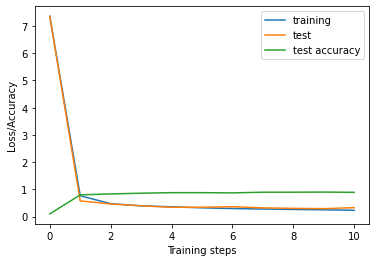

In [6]:
import matplotlib.pyplot as plt

# Visualize accuracy and loss for training and test data.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2, line3),("training","test", "test accuracy"))
plt.show()